In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import copy
import cv2 as cv
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering

import plotly.express as px
import pandas as pd
import umap.umap_ as umap
import pickle
sys.path.append('../')
from vae_functions import *

g:\venvs\p39_un\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


images (310080, 2, 32, 32)
lacina (310080, 32, 32)


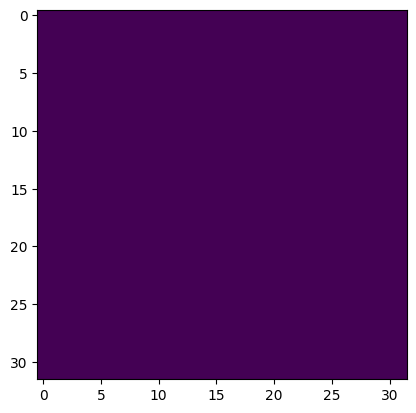

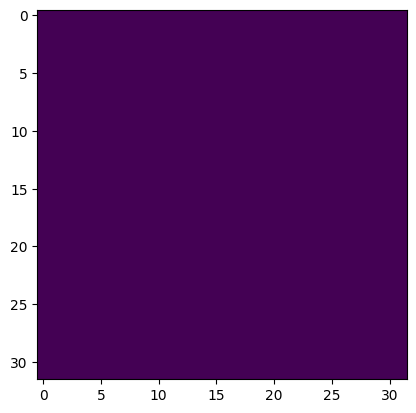

lacina (103886, 32, 32) --no spaces
lacina (103886, 32, 32, 1) --good shape


In [2]:
cluster_hiragana = np.load("cluster_hiragana_35.npy")
cluster_latin = np.load("cluster_latin_37.npy")
latin_datasets, hiragana_datasets = read_dataset_no_spaces(PATH)

latin_datasets = latin_datasets[:len(cluster_latin)]
hiragana_datasets = hiragana_datasets[:len(cluster_hiragana)]

path_to_page = 'E:/Studia/SIiUM/sem2/UNN/1_sign_per_class_no_distortions_whole_book/hiragana_img/hiragana_page_6.png'
path_to_page1 = 'E:/Studia/SIiUM/sem2/UNN/1_sign_per_class_no_distortions_whole_book/hiragana_img/hiragana_page_1.png'

hiragana_page = cv.imread(path_to_page, 0)
hiragana_page1 = cv.imread(path_to_page1, 0)

autoencoder_hiragana = read_vae('E:/Studia/SIiUM/sem2/UNN/vaeEncoder_hiragana', 'E:/Studia/SIiUM/sem2/UNN/vaeDecoder_hiragana')


In [4]:
spec = SpectralClustering(n_clusters = 35, n_init = 100)
_, _, pred = autoencoder_hiragana.encoder.fit_predict(hiragana_datasets, verbose = 0)
predicted_classes = spec.fit(pred)

AttributeError: 'Functional' object has no attribute 'fit_predict'

In [3]:
filename_hiragana = 'E:/Studia/SIiUM/sem2/UNN/spec_hiragana_model.sav'
filename_latin = 'E:/Studia/SIiUM/sem2/UNN/spec_latin_model.sav'
loaded_model_latin = pickle.load(open(filename_latin, 'rb'))
loaded_model_hiragana = pickle.load(open(filename_hiragana, 'rb'))

In [39]:
def remap_to_lower_class(cluster: np.ndarray, length: int) -> np.ndarray:
    cluster = copy.deepcopy(cluster)
    min_number = length - 1
    max_number = np.max(cluster)
    # print(f"min_number: {min_number}, max_number: {max_number}")
    for i in range(min_number + 1, max_number + 1):
        if i <= np.max(cluster):
            # print(f"latin: {i}")
            cluster[cluster == i] = min_number

    return cluster[0]

def create_class_map(datasets: np.ndarray, labels: np.ndarray, length: int) -> dict:
    vals, counts = np.unique(labels, return_counts=True)
    # print(f"vals: {vals}")
    map_dict = {}
    for i, id in enumerate(vals):
        # if i > length: break
        map_dict[id] = datasets[random.choice(np.argwhere(labels == id))].reshape(32,32)
    return map_dict

# def compere_map_length(map_latin, map_hiragana):
#     latin = copy.deepcopy(map_latin)
#     hiragana = copy.deepcopy(map_hiragana)
#     min_number = np.min([np.max(list(latin.keys())), np.max(list(hiragana.keys()))])
#     max_number = np.max([np.max(list(latin.keys())), np.max(list(hiragana.keys()))])

#     for i in range(min_number + 1, max_number + 1):
#         if i in list(latin.keys()):
#             del latin[i]
#         if i in list(hiragana.keys()):
#             del hiragana[i]
#     return latin, hiragana
def show_3d(predictions, labels):
    data_3d = umap.UMAP(n_neighbors = 10, min_dist = 0.1, n_components = 3, n_epochs = 300, metric = 'correlation').fit_transform(predictions)
    df = pd.DataFrame(data_3d, columns = ['x', 'y', 'z'])
    fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', color = labels, color_continuous_scale = "jet", width = 1000, height = 800)
    fig.update_traces(marker = dict(size = 1))
    fig.show()

def generate_decode_list(labels_latin: np.ndarray, labels_hiragana: np.ndarray) -> list:
    vals_latin, counts_latin = np.unique(labels_latin, return_counts=True)
    # print(f"vals_latin: {vals_latin}, counts_latin: {counts_latin}")
    latin_sorted, _ = zip(*sorted(zip(vals_latin, counts_latin), key = lambda x:x[1]))
    latin_sorted = latin_sorted[::-1]
    vals_hiragana, counts_hiragana = np.unique(labels_hiragana, return_counts=True)
    # print(f"vals_hiragana: {vals_hiragana}, counts_hiragana: {counts_hiragana}")

    hiragana_sorted, _ = zip(*sorted(zip(vals_hiragana, counts_hiragana), key = lambda x:x[1]))
    hiragana_sorted = hiragana_sorted[::-1]

    hiragana_to_latin = {}
    # print(f"latin_sorted: {latin_sorted}")
    # print(f"hiragana_sorted: {hiragana_sorted}")
    for i in range(len(hiragana_sorted)):
        if len(latin_sorted) < i:
            hiragana_to_latin[hiragana_sorted[i]] = latin_sorted[len(hiragana_sorted)]
        else:
            hiragana_to_latin[hiragana_sorted[i]] = latin_sorted[i]
    # print(f"hiragana_to_latin: {hiragana_to_latin}")
    
    return hiragana_to_latin

def find_space_id(datasets: np.ndarray, noise: bool) -> np.ndarray:
    space_id = []
    mark_id = []
    coef = 0.1 if noise else 0.05
    for i in range(len(datasets)):
        value, count = np.unique(datasets[i], return_counts= True)
        # print(count, value, count[0]/count[-1] )
        # if count[0]/count[-1] > coef or count[0] == count[-1]:
        if count[0] == count[-1]:
            space_id.append(i)
        else:
            mark_id.append(i)
        # plt.imshow(dataset[i], cmap='binary')
        # plt.show()
    return np.array(mark_id), np.array(space_id)

def cut_page(page: np.ndarray, dataset: list = None):
    column_num = 80
    row_num = 114
    letter_size = 32
    dataset = []

    for row in range(row_num):
        for column in range(column_num):
            # print(f"row_num*letter_size:row_num*letter_size + letter_size: {row*letter_size} {row*letter_size + letter_size}")
            # print(f"column_num*letter_size:column_num*letter_size + letter_size: {column*letter_size} {column*letter_size + letter_size}")
            letter = page[row*letter_size:row*letter_size + letter_size, column*letter_size:column*letter_size + letter_size]
            dataset.append(letter)

    return np.array(dataset)

def spectral_clustering(predictions, spec_model: SpectralClustering) -> np.ndarray:
    predicted_classes = spec_model.fit_predict(predictions)
    show_3d(predictions, predicted_classes)

    return predicted_classes

def cluster_dataset(encoder: VAE, dataset: np.ndarray, spec_model: SpectralClustering, num_cluster: int = 35):
    _, _, pred = encoder.encoder.fit_predict(dataset, verbose = 0)
    cluster = spectral_clustering(pred, spec_model)
    return cluster, pred

def descrypt_page(page: np.ndarray, page_cluster_label: np.ndarray, latin_dict: dict, hiragana_to_latin: dict, mark_id: list) -> np.ndarray:
    column_num = 80
    row_num = 114
    letter_size = 32
    page_latin = copy.deepcopy(page)
    space = np.ones((32,32)) * 255
    label_number = 0
    iter = 0
    for row in range(row_num):
        for column in range(column_num):
            if iter in mark_id:
                # print(f"iter: {iter}, label_number: {label_number}, page_cluster_label[label_number]: {page_cluster_label[label_number]}, hiragana_to_latin[page_cluster_label[label_number]]: {hiragana_to_latin[page_cluster_label[label_number]]}")
                page_latin[row*letter_size:row*letter_size + letter_size, column*letter_size:column*letter_size + letter_size] = latin_dict[hiragana_to_latin[page_cluster_label[label_number]]]
                label_number += 1
            else:
                page_latin[row*letter_size:row*letter_size + letter_size, column*letter_size:column*letter_size + letter_size] = space
            iter += 1
    return page_latin

In [5]:
# cluster_latin_lower = remap_to_lower_class(cluster_latin[np.newaxis], 35)
# print(f"max(cluster_latin_lower): {np.max(cluster_latin_lower)}")
# cluster_hiragana_lower = remap_to_lower_class(cluster_hiragana[np.newaxis], 35)
# print(f"max(cluster_hiragana_lower): {np.max(cluster_hiragana_lower)}")

# latin_lower = np.array(np.unique(cluster_latin_lower, return_counts=True)).T
# hiragana_lower = np.array(np.unique(cluster_hiragana_lower, return_counts=True)).T

In [6]:
hiragana_to_latin = generate_decode_list(cluster_latin[:,np.newaxis], cluster_hiragana[:,np.newaxis])
latin_datasets[latin_datasets == 1] = 255
hiragana_datasets[hiragana_datasets == 1] = 255
map_latin = create_class_map(latin_datasets, cluster_latin, 35)
map_hiragana = create_class_map(hiragana_datasets, cluster_hiragana, 35)

In [7]:
# for i in range(35):
#     plt.imshow(map_latin[i])
#     plt.show()

In [41]:
dataset_hiragana = cut_page(hiragana_page)
# dataset_hiragana = cut_page(hiragana_page1, list(dataset_hiragana_0))

dataset_hiragana[dataset_hiragana == 1] = 255
mark_id, space_id = find_space_id(dataset_hiragana, False)
cluster_label, pred = cluster_dataset(autoencoder_hiragana, dataset_hiragana[mark_id], loaded_model_hiragana, 35)


AttributeError: 'Functional' object has no attribute 'fit_predict'

In [30]:
page_latin = descrypt_page(hiragana_page1, cluster_label, map_latin, hiragana_to_latin, mark_id)

In [ ]:
len(dataset_hiragana[mark_id])

4874

: 

: 

In [ ]:
# page_latin = descrypt_page(hiragana_page, cluster_hiragana, map_latin, hiragana_to_latin, mark_id)


: 

: 

In [31]:
import matplotlib.image as mplimg

mplimg.imsave(f'test3.png',
                page_latin, cmap='gray')

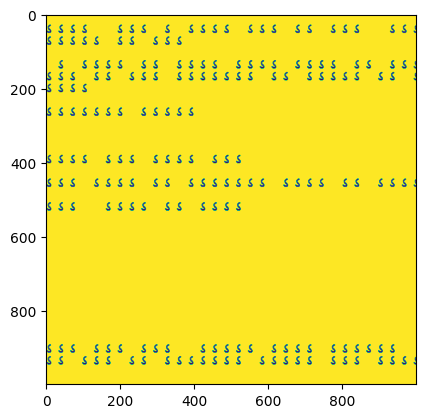

: 

: 

In [ ]:
plt.imshow(page_latin[1000:2000, 1000:2000])
plt.show()